In [1]:
from quantumblur import *
import quantumblur as qb
import numpy as np

def make_swirl(Lx,Ly):
    swirl = {}
    for x in range(Lx):
        for y in range(Ly):
            xx, yy = (x-Lx/2), (y-Ly/2)
            d = (xx**2 + yy**2)**0.5
            theta = np.arctan2(yy,xx)
            swirl[x,y] = (1+np.sin(d/10+3*theta))/2
    return swirl

swirl = make_swirl(256,256)

In [2]:
def blur_strips(height, points, radius, strength, method='rx', rotate=False):
    """
    Applies Quantum Blur to a heighmap on a region defined by a radius
    and a set of points.

    Args:
        height (dict): a dictionary in which keys are coordinates
            for points on a grid, and the values are positive numbers
            from 0 to 1.
        points (list): a list of coordinates from the height map.
        radius (int): width (or height) of the strips formed between
            successive pairs of points, on which Quantum Blur is
            applied.
        strength (float): strength of the effect between 0 and 1.
        method (str): Type of rotation or effect to use. Should be
            `'rx'` or `'ry'`.
        rotate (bool): By default, strips have a fixed width. For
            rotate=True, they will instead have a fixed height.

    Returns:
        height (dict): A modifed height map.
    """

    L = qb._get_size(height)
    new_height = height.copy()

    if rotate:
        for j, point in enumerate(points):
            points[j] = point[::-1]

    # radius must be rounded up to next power of 2
    radius = int(2**np.ceil(np.log2(radius)))

    origins = [] # coordinate of where the (0,0) points in the grids are in the height map
    grids = [] # grids for strips
    for j in range(len(points)-1):

        # the base point is the one with lowest y value
        if points[j][1] < points[j+1][1]:
            p0 = points[j]
            p1 = points[j+1]
        else:
            p0 = points[j+1]
            p1 = points[j]
        # origin is half the radius from base point
        origins.append((p0[0]-radius//2, p0[1]))
        if rotate:
            origins[-1] = origins[-1][::-1]

        Dx = p1[0] - p0[0] # total x offset of the strip
        h = p1[1] - p0[1] # height of the strip

        # calculate required offsets
        offset = [0]
        for y in range(1,h):
            offset.append((y*Dx)//h)

        grids.append(qb.make_strip(offset, radius, rotate=rotate))

    for (x0,y0), (grid,n) in zip(origins, grids):
        # get the height map of the strip
        strip_height = {}
        for _, (dx, dy) in grid.items():
            # get positions in the height map (and reflect them back if they go over)
            pos = [x0 + dx, y0 + dy]
            for j, c in enumerate(pos):
                if c>=L[j]:
                    c = 2*(L[j]-1)-c
                if c<0:
                    c = abs(c)
                pos[j] = c
            strip_height[dx, dy] = new_height[tuple(pos)]
        # blur strip
        qc = qb.height2circuit(strip_height, grid=grid, log=(method=='ry'))
        if method=='swap':
            reg = n//2
            for q in range(reg):
                qc.cx(q, q + reg)
                qc.crx(strength * np.pi, q + reg, q)
                qc.cx(q, q + reg)
        else:
            for q in range(n):
                if method=='rx':
                    qc.rx(strength*np.pi/2, q)
                elif method=='ry':
                    qc.ry(strength*np.pi/2, q)
        strip_height =qb.circuit2height(qc, grid=grid, log=(method=='ry'))
        # update height map
        for _, (dx, dy) in grid.items():
            pos = (x0 + dx, y0 + dy)
            if pos in height:
                new_height[pos] = strip_height[dx, dy]

    return new_height

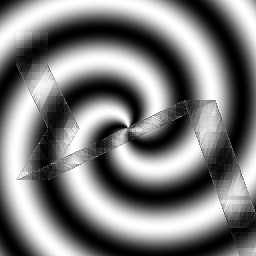

In [3]:
points = [(32,32),(32,64),(64,128),(32,180),(200,100),(256,256)]
radius = 30
strength = 0.15
method = 'rx'

new_swirl = blur_strips(swirl, points, radius, strength, method=method)
qb.height2image(new_swirl)

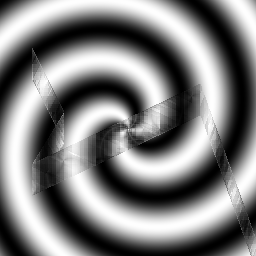

In [4]:
new_swirl = blur_strips(swirl, points, radius, strength, method=method, rotate=True)
qb.height2image(new_swirl)